In [1]:
from sklearn.cross_decomposition import CCA
import numpy as np
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import pickle
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

**Plot the hand and target kinematics for the controller obtained after training / testing in configs/monkey_configs_test.txt**

In [2]:
#Load the kinematics for hand and target in the simulation
#The corresponding kinematics file will be saved as test_kinematics_hand(/target)_test_data_filename(in test configs file)

hand_kin = np.load("./kinematics_hand_test.npy")
target_kin = np.load("./kinematics_target_test.npy")

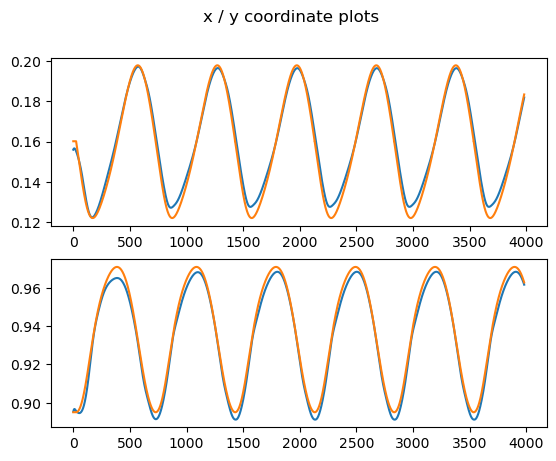

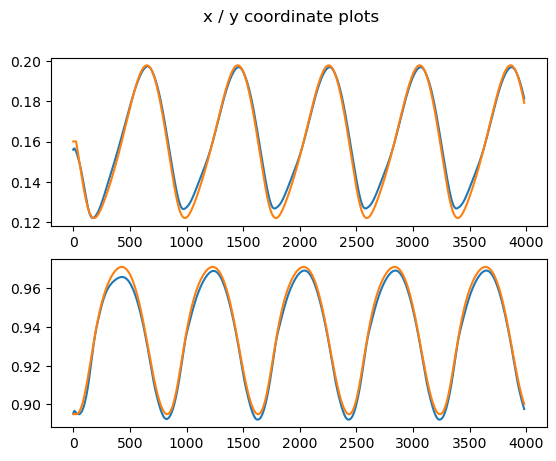

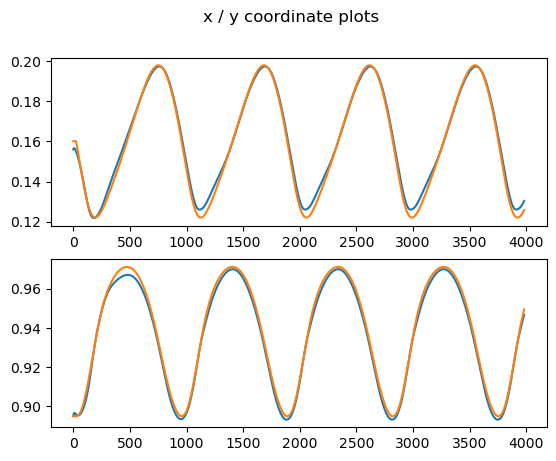

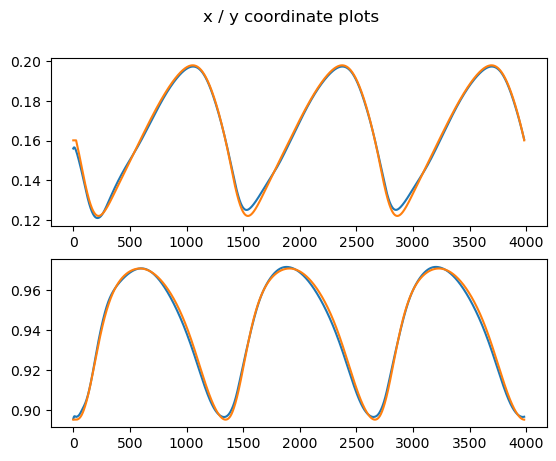

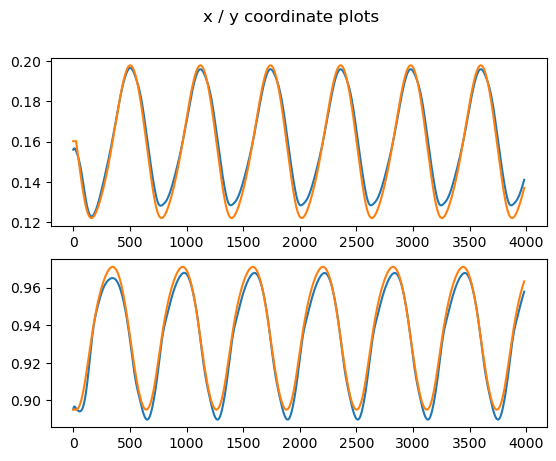

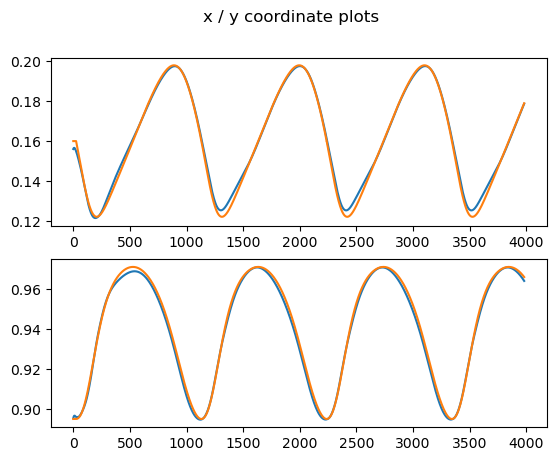

In [3]:
#Plot musim kinematics with targets for easy visualization
#kin shape: [n_test+train_conds, simulation_timepoints, 3]

for i_cond in range(hand_kin.shape[0]):
    #Get the hand and target kinematics for the given condition
    h_x = hand_kin[i_cond, :, 0]
    h_y = hand_kin[i_cond, :, 2]
    
    t_x = target_kin[i_cond, :, 0]
    t_y = target_kin[i_cond, :, 2]
    
    fig, axs = plt.subplots(2)
    fig.suptitle('x / y coordinate plots')
    
    axs[0].plot(h_x)
    axs[0].plot(t_x)
    
    axs[1].plot(h_y)
    axs[1].plot(t_y)
    
    plt.show()

**Load the muSim and saved experimental neural data for the monkey cycling task**

In [4]:
#Load experimental for training and testing

with open("./monkey/monkey_data/neural_activity_train.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    exp_train = pickle.load(file)

with open("./monkey/monkey_data/neural_activity_test.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    exp_test = pickle.load(file)

    
#Load the nusim activities for training and testing
nusim_activity_train_test = np.load("./hidden_act_test.npy")

nusim_train = {}
for i_cond in range(len(exp_train)):
    nusim_train[i_cond] = nusim_activity_train_test[i_cond]
    #Select timepoints for analysis
    # Skip the first fixed number of timesteps for which the target is constant
    # The fixedsteps should be equal to self.n_fixedsteps in SAC/RL_Framework_Mujoco.py
    nusim_train[i_cond] = nusim_train[i_cond][25+2*exp_train[i_cond].shape[0]:25+3*exp_train[i_cond].shape[0], :]
    #Apply gaussian filtering
#     nusim_train[i_cond] = gaussian_filter1d(nusim_train[i_cond].T, 20).T
    
nusim_test = {}
for i_cond in range(len(exp_test)):
    nusim_test[i_cond] = nusim_activity_train_test[i_cond+len(exp_train)]
    nusim_test[i_cond] = nusim_test[i_cond][25+2*exp_test[i_cond].shape[0]:25+3*exp_test[i_cond].shape[0], :]
#     nusim_test[i_cond] = gaussian_filter1d(nusim_test[i_cond].T, 20).T

**muSim population dynamics: Collective PCA for all muSim activities**

<IPython.core.display.Javascript object>


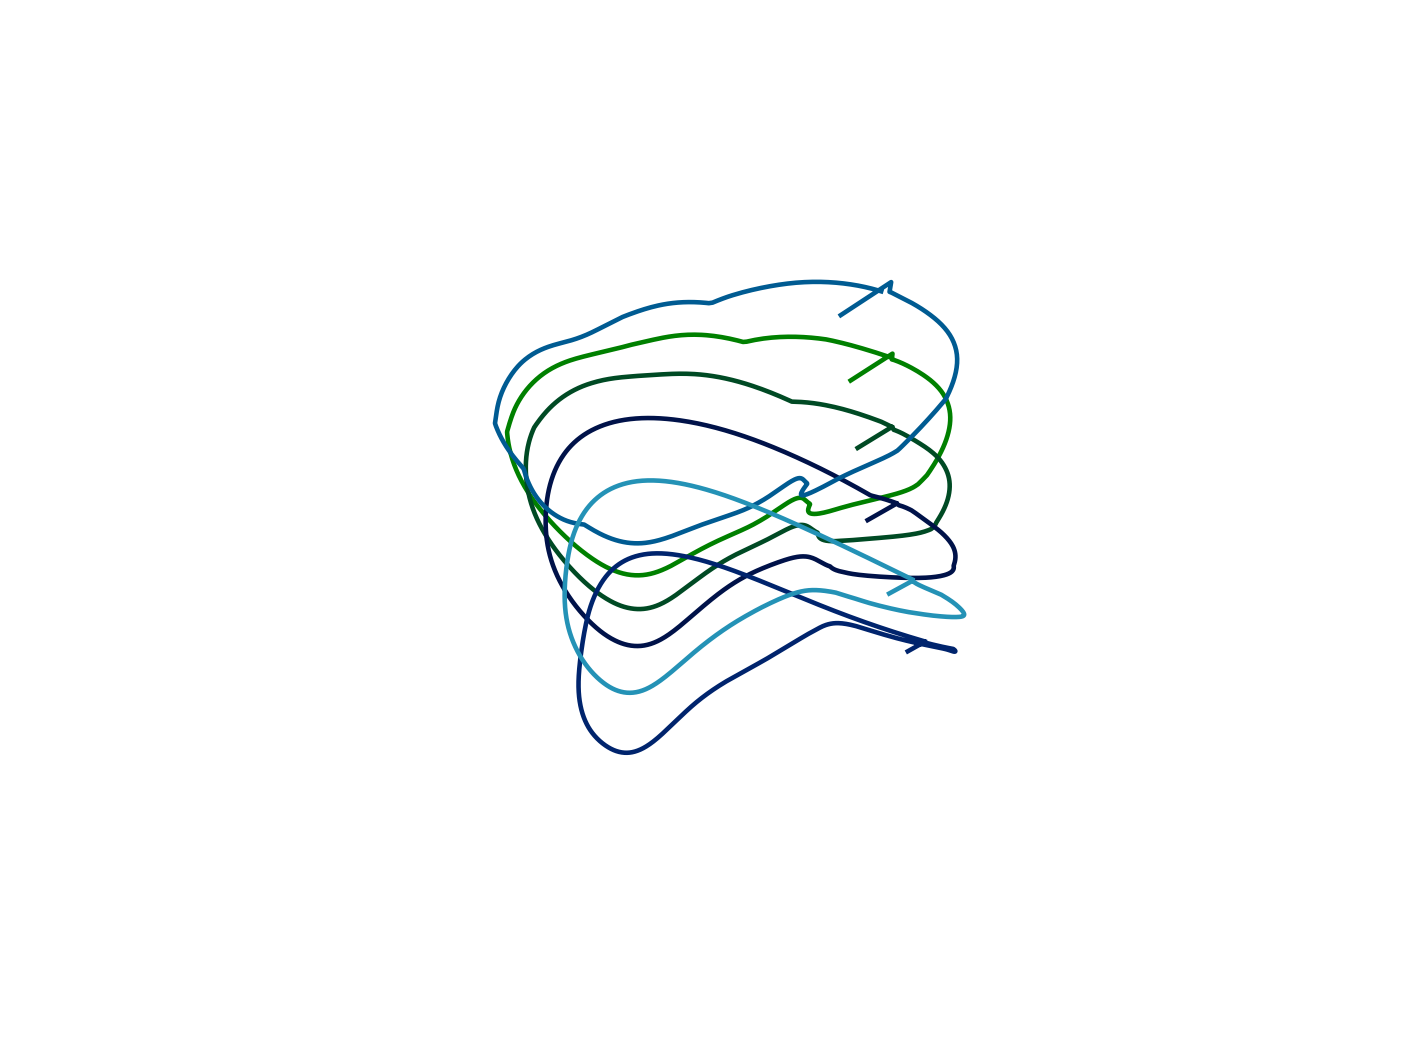

In [5]:
%matplotlib notebook

#Do the collective PCA for all speeds
nusim_pca = PCA(n_components= 3)

#concatenate the musim activity for all conditions
for i_cond in range(len(nusim_train)):
    
    if i_cond == 0:
        nusim_activity_pca = nusim_train[i_cond]
    else:
        nusim_activity_pca = np.concatenate((nusim_activity_pca, nusim_train[i_cond]), axis=0)
        
for i_cond in range(len(nusim_test)):
    nusim_activity_pca = np.concatenate((nusim_activity_pca, nusim_test[i_cond]), axis=0)

nusim_activity_pca = nusim_pca.fit_transform(nusim_activity_pca)

#Plot the PCA of the activities
colors = plt.cm.ocean(np.linspace(0,1,8))
ax = plt.figure(dpi=100).add_subplot(projection='3d')

prev_cond = 0
for i_cond in range(len(nusim_train)):
    ax.plot(nusim_activity_pca[prev_cond:prev_cond+nusim_train[i_cond].shape[0],0], 
            nusim_activity_pca[prev_cond:prev_cond+nusim_train[i_cond].shape[0], 1], 
            nusim_activity_pca[prev_cond:prev_cond+nusim_train[i_cond].shape[0], 2], color= colors[i_cond])
    
    prev_cond += nusim_train[i_cond].shape[0]
    
for i_cond in range(len(nusim_test)):
    ax.plot(nusim_activity_pca[prev_cond:prev_cond+nusim_test[i_cond].shape[0],0], 
            nusim_activity_pca[prev_cond:prev_cond+nusim_test[i_cond].shape[0], 1], 
            nusim_activity_pca[prev_cond:prev_cond+nusim_test[i_cond].shape[0], 2], color= colors[i_cond+len(nusim_train)])
    
    prev_cond += nusim_test[i_cond].shape[0]
    
# Hide grid lines
ax.grid(False)
plt.grid(b=None)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.axis('off')

plt.show()

**Load EMG, Kinematics and Open Loop RNN activities**

In [6]:
#Load emg for training and testing

with open("./Neural_Analysis/Training/emg_train.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    emg_train = pickle.load(file)

with open("./Neural_Analysis/Testing/emg_test.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    emg_test = pickle.load(file)

#Load kinematics for training and testing

with open("./Neural_Analysis/Training/kin_train.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    kin_train = pickle.load(file)

with open("./Neural_Analysis/Testing/kin_test.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    kin_test = pickle.load(file)

#Load the RNN activities for training and testing

with open("./Neural_Analysis/Training/RNN_train.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    rnn_train = pickle.load(file)

with open("./Neural_Analysis/Testing/RNN_test.pkl", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    rnn_test = pickle.load(file)

In [7]:
#------------- R2 array for the agent policy network ----------------------------

#Load the experimental activities

A_exp_s1 = exp_test[0]

A_exp_s2 = exp_train[0]

A_exp_s3 = exp_train[1]

A_exp_s4 = exp_train[2]

A_exp_s5 = exp_test[1]

A_exp_s6 = exp_train[3]

In [8]:
#Load the DRL/agent activities

A_musim_s1 = nusim_test[0]

A_musim_s2 = nusim_train[0]

A_musim_s3 = nusim_train[1]

A_musim_s4 = nusim_train[2]

A_musim_s5 = nusim_test[1]

A_musim_s6 = nusim_train[3]

In [9]:
#Load the open loop RNN activities

A_RNN_s1 = rnn_test[0]
A_RNN_s2 = rnn_train[0]
A_RNN_s3 = rnn_train[1]
A_RNN_s4 = rnn_train[2]
A_RNN_s5 = rnn_test[1]
A_RNN_s6 = rnn_train[3]

**Sample analysis of muSim vs Open Loop RNN**

0.8720827790631402
-4.460341890684303


<IPython.core.display.Javascript object>


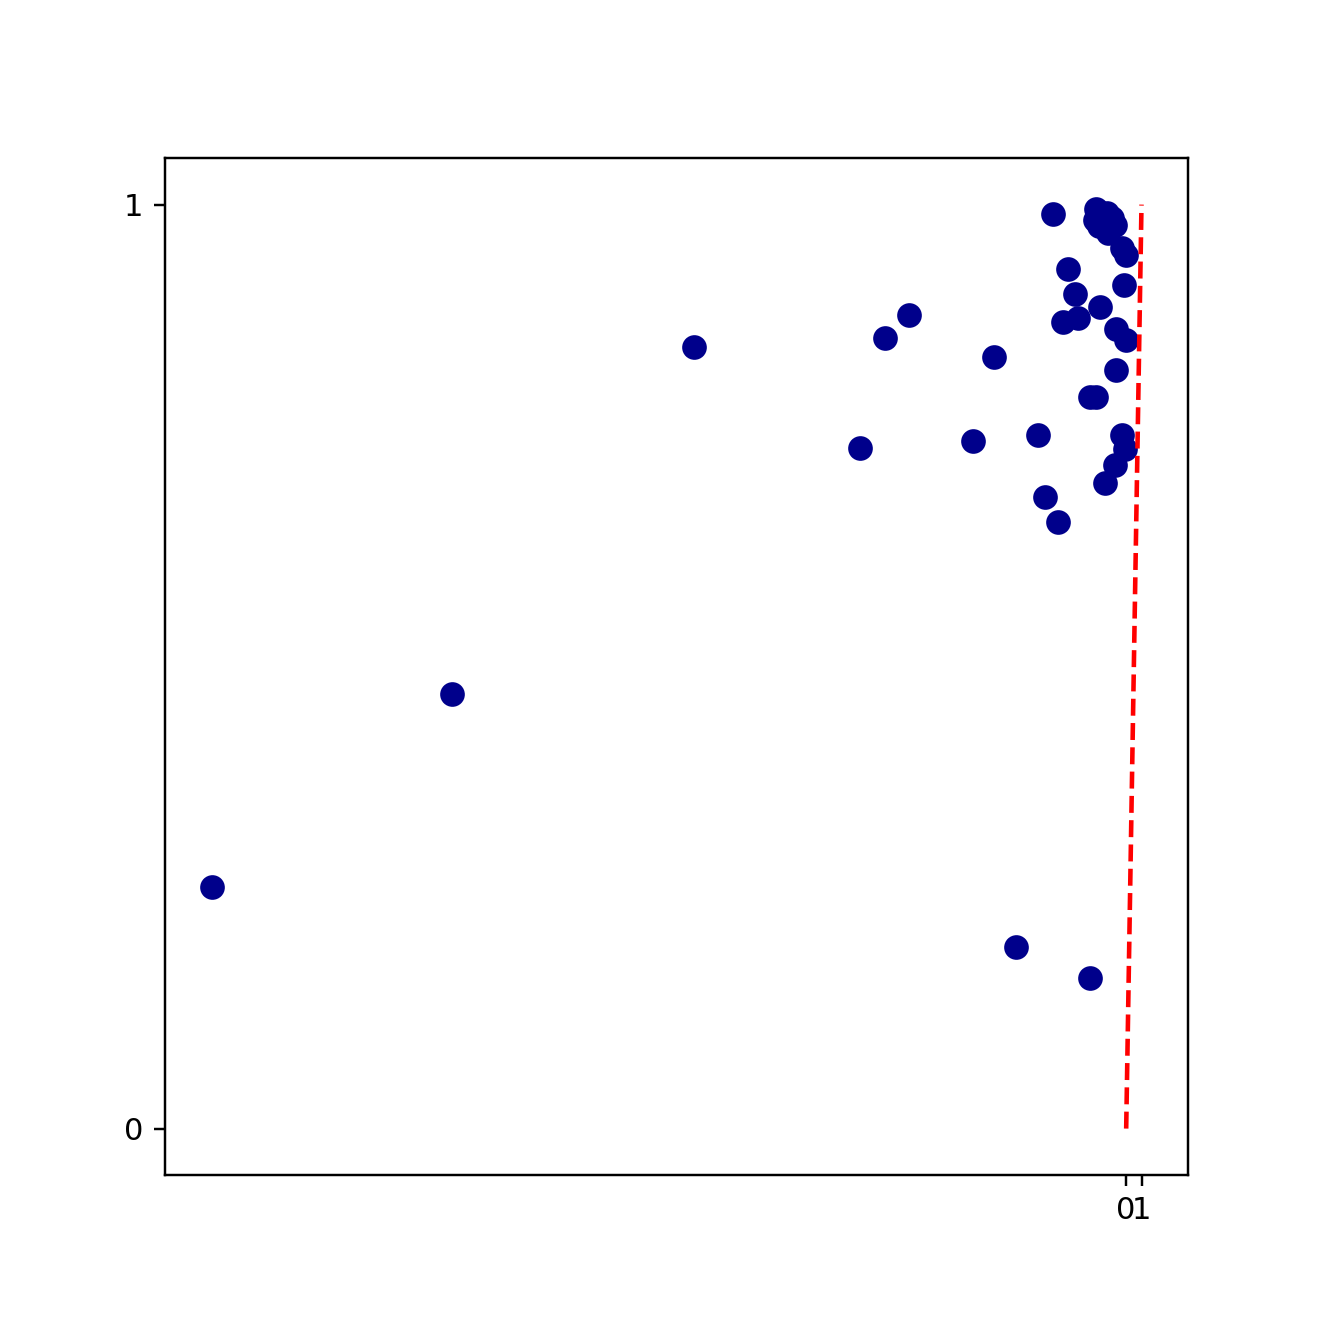

<IPython.core.display.Javascript object>


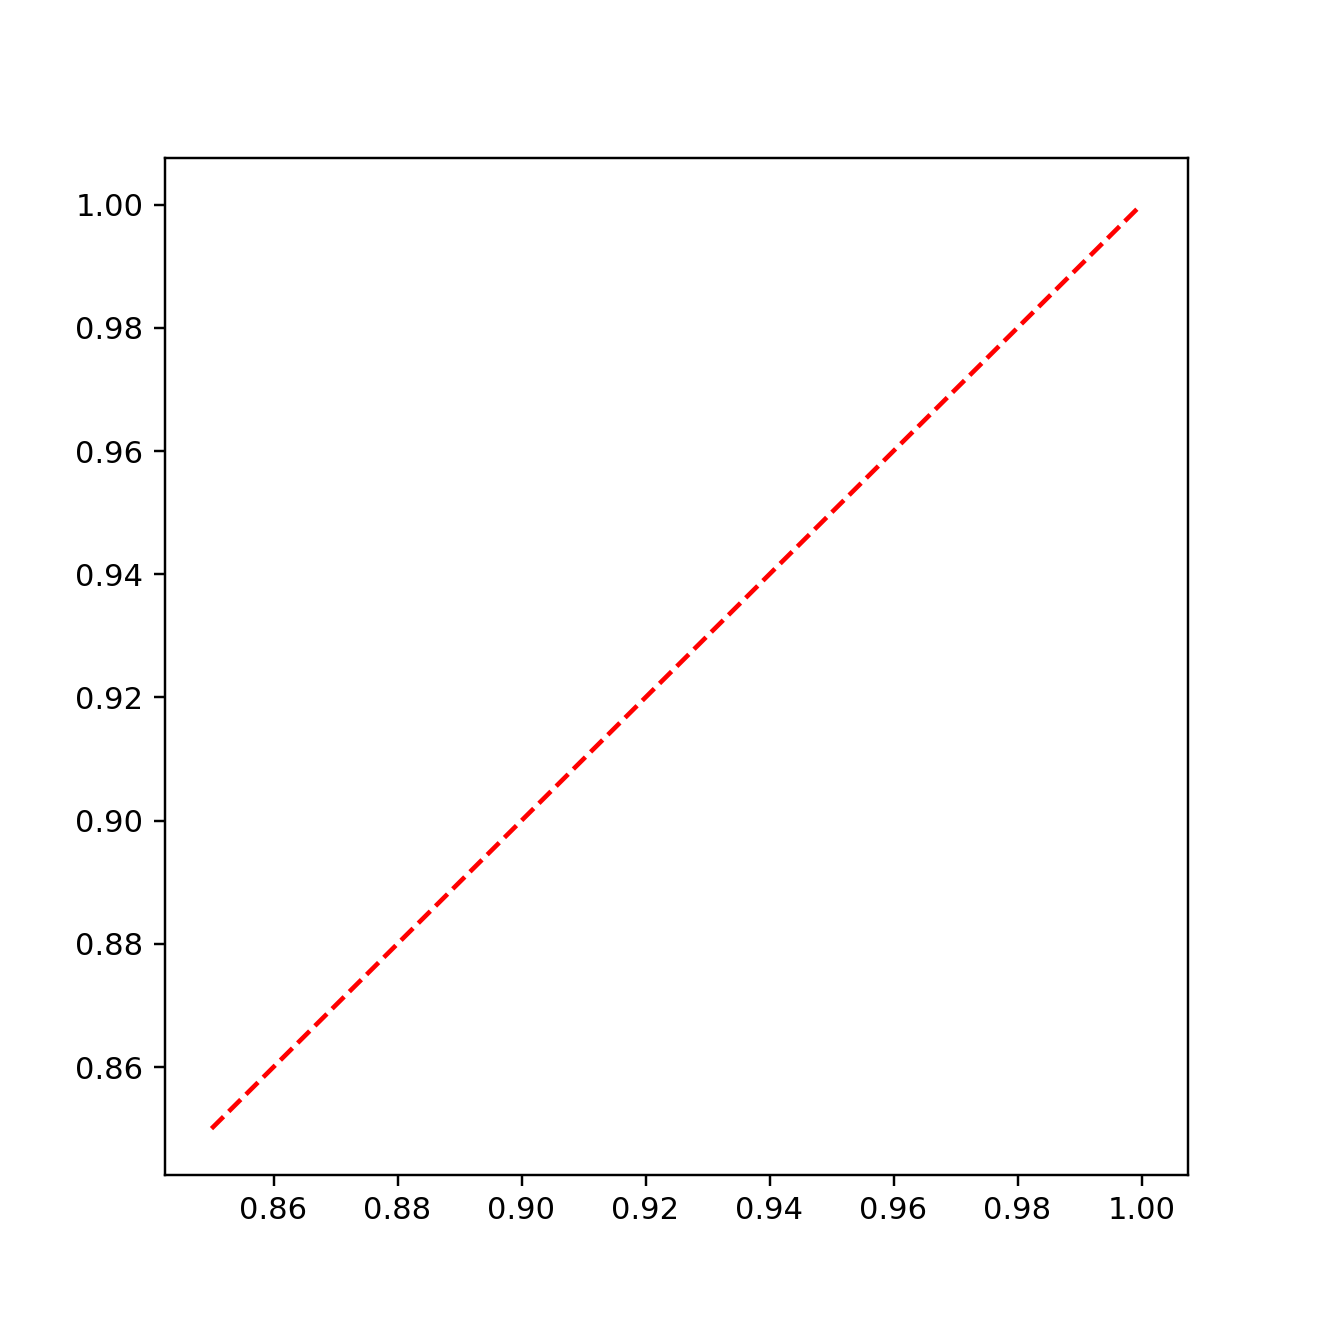

In [10]:
#Sample code for comparing DRL vs Open Loop RNN
#The code for complete analysis(vs EMG, Kinematics) is also given below

#
A_musim = np.concatenate((A_musim_s2, A_musim_s3, A_musim_s4, A_musim_s5, A_musim_s6), axis= 0)
A_exp = np.concatenate((A_exp_s2, A_exp_s3, A_exp_s4, A_exp_s5, A_exp_s6), axis=0)

reg_net = Ridge(alpha= 5e-02).fit(A_musim, A_exp)

pred_net = reg_net.predict(A_musim_s1)
print(r2_score(A_exp_s1, pred_net, multioutput= 'variance_weighted'))

r2_list = []

for k in range(pred_net.shape[1]):
    r_val = r2_score(A_exp_s1[:,k], pred_net[:, k])
    r2_list.append(r_val)
r2_array_net = np.array(r2_list)

A_RNN = np.concatenate((A_RNN_s2, A_RNN_s3, A_RNN_s4, A_RNN_s5, A_RNN_s6), axis= 0)

reg_RNN = Ridge(alpha= 5e-02).fit(A_RNN, A_exp)
pred_RNN = reg_RNN.predict(A_RNN_s1)

print(r2_score(A_exp_s1, pred_RNN, multioutput= 'variance_weighted'))

r2_list = []

for k in range(pred_RNN.shape[1]):
    r_val = r2_score(A_exp_s1[:,k], pred_RNN[:, k])
    r2_list.append(r_val)
# print(r2_list)
r2_array_RNN = np.array(r2_list)

# -------------------- Plan of action ------------------------------
## Find r2_array_network and r2_array_emg. Find r2_array_network - r2_array_emg. Sort the resulting array in the
#  ascending order using argsort. Now plot the reconstructions in the ascending order using the already developed
# logic


### ------------- Plot the scatter plot ------------------------------------------------------
filter1 = np.where(np.logical_or(r2_array_net>=0, r2_array_RNN>=0))
filter2 = np.where(np.logical_and(r2_array_RNN>=0, r2_array_RNN<=1))
filter = np.intersect1d(filter1, filter2)

plt.figure(figsize= (6, 6))

plt.scatter(r2_array_RNN[filter1], r2_array_net[filter1], s=50, c= 'darkblue')
plt.plot([0, 1], [0, 1], '--', c= 'r', linewidth= 1.5)

plt.xticks([0, 1], ['0', '1'], size= 10)
plt.yticks([0, 1], ['0', '1'], size= 10)
plt.show()

### ------------- Plot the scatter plot ------------------------------------------------------
filter1 = np.where(np.logical_and(r2_array_net>=0.85, r2_array_net<=1))
filter2 = np.where(np.logical_and(r2_array_RNN>=0.85, r2_array_RNN<=1))
filter = np.intersect1d(filter1, filter2)

plt.figure(figsize= (6, 6))

plt.scatter(r2_array_RNN[filter], r2_array_net[filter], s=50, c= 'darkblue')
plt.plot([0.85, 1], [0.85, 1], '--', c= 'r', linewidth= 1.5)

# plt.xticks([0, 1], ['0', '1'], size= 10)
# plt.yticks([0, 1], ['0', '1'], size= 10)
plt.show()